# Implementation of NIDS Paper

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.feature_extraction.text import HashingVectorizer


## Read Data and Preliminary Analysis

In [4]:
features = pd.read_csv('NetFlow_v2_Features.csv')
data = pd.read_csv('NF-ToN-IoT-v2.csv')

In [5]:
features

,Feature,Description
0,IPV4_SRC_ADDR,IPv4 source address
1,IPV4_DST_ADDR,IPv4 destination address
2,L4_SRC_PORT,IPv4 source port number
3,L4_DST_PORT,IPv4 destination port number
4,PROTOCOL,IP protocol identifier byte
5,L7_PROTO,Layer 7 protocol (numeric)
6,IN_BYTES,Incoming number of bytes
7,OUT_BYTES,Outgoing number of bytes
8,IN_PKTS,Incoming number of packets
9,OUT_PKTS,Outgoing number of packets


In [6]:
categorical = ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR']
numeric = ['IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'FLOW_DURATION_MILLISECONDS','DURATION_IN', 'DURATION_OUT', 'MIN_TTL', 'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES', 'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS', 'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES', 'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES', 'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT','DNS_TTL_ANSWER']
hashed_categorical = ['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO','TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS','ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE','FTP_COMMAND_RET_CODE' ]
print(f'Number of Features: [Categorical: {len(categorical)}], [Numeric: {len(numeric)}], [Hashed_Categorical]: {len(hashed_categorical)}')

Number of Features: [Categorical: 2], [Numeric: 29], [Hashed_Categorical]: 12


This division of features is not given in the methodology of the paper and is important to know as it determines which method transformer is utilized on which feature, but we went with the most sensible options. We tried others as well and this gives results closest to the paper.

In [7]:
print(len(data))

16940496


In [8]:
sampled_data = data.sample(frac=0.1)

Like in the paper, we take 10% of the total data while ensuring similar distribution (as seen below)

In [9]:
column_counts = data['Attack'].value_counts()
total_count = len(data['Attack'])

column_percentages = (column_counts / total_count) * 100

frequency_table = pd.DataFrame({'Frequency': column_counts, 'Percentage': column_percentages})

print(frequency_table)

            Frequency  Percentage
Attack                           
Benign        6099469   36.005256
scanning      3781419   22.321773
xss           2455020   14.492020
ddos          2026234   11.960889
password      1153323    6.808083
dos            712609    4.206542
injection      684465    4.040407
backdoor        16809    0.099224
mitm             7723    0.045589
ransomware       3425    0.020218


In [10]:
column_counts = sampled_data['Attack'].value_counts()
total_count = len(sampled_data['Attack'])

column_percentages = (column_counts / total_count) * 100

frequency_table = pd.DataFrame({'Frequency': column_counts, 'Percentage': column_percentages})

print(frequency_table)

            Frequency  Percentage
Attack                           
Benign         609012   35.950061
scanning       378483   22.341903
xss            245294   14.479738
ddos           203075   11.987545
password       115019    6.789587
dos             71474    4.219120
injection       68878    4.065878
backdoor         1702    0.100469
mitm              793    0.046811
ransomware        320    0.018890


## Supervised Learning Tasks

In [11]:
X = sampled_data.drop(columns=['Label','Attack'])
y = sampled_data['Label']

In [12]:
numeric_features = X[numeric].columns
categorical_features = X[categorical].columns
hashed_categorical_features = X[hashed_categorical].columns

Next we use the transformations as mentioned in the paper.

In [13]:
numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = CountVectorizer()
hashed_categorical_transformer = HashingVectorizer(n_features=10)

In [14]:
X_numeric = numeric_transformer.fit_transform(X[numeric_features])

In [15]:
vectorized_df = pd.DataFrame()

for col in categorical:
    temp = categorical_transformer.fit_transform(X[col].astype(str))
    
    col_names = [col + '_' + name for name in categorical_transformer.get_feature_names_out()]
    vectorized_col_df = pd.DataFrame(temp.toarray(), columns=col_names)
    
    vectorized_df = pd.concat([vectorized_df, vectorized_col_df], axis=1)

X_categorical = vectorized_df

In [16]:
hashed_df = pd.DataFrame()

for col in hashed_categorical:
    temp = hashed_categorical_transformer.transform(X[col].astype(str))
    
    col_names = [col + '_hash_' + str(i) for i in range(temp.shape[1])]
    hashed_col_df = pd.DataFrame(temp.toarray(), columns=col_names)
    
    hashed_df = pd.concat([hashed_df, hashed_col_df], axis=1)

X_hashed = hashed_df

In [17]:
X_combined = np.hstack((X_numeric, X_categorical, X_hashed))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.1, random_state=42)

In [19]:
scalers = {
    'MaxAbsScaler': MaxAbsScaler(),
    'StandardScaler': StandardScaler(),
    'SparseNormalizer': Normalizer()
}

classifiers = {
    'XGBoost': XGBClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier()
}

We applied the same methods as the paper did in their Azure pipeline

In [ ]:
results = []
for scaler_name, scaler in scalers.items():
    for classifier_name, classifier in classifiers.items():
        #print(scaler_name,classifier_name)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        classifier.fit(X_train_scaled, y_train)
        
        y_pred = classifier.predict(X_test_scaled)
        
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results.append({
            'Scaler': scaler_name,
            'Classifier': classifier_name,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1-Score': f1
        })

results_df = pd.DataFrame(results)
display(results_df)

C:\Users\anike\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Our results are marginally better than the papers as can be seen below

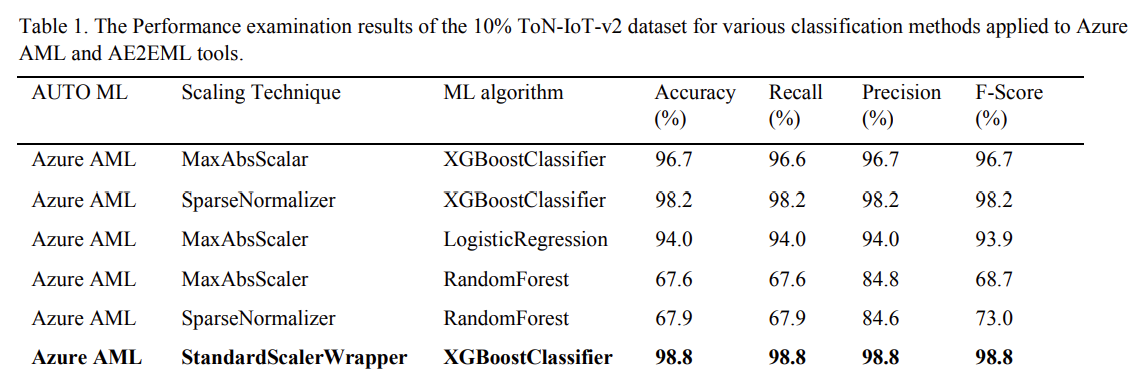

## Unsupervised Learning Tasks

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, homogeneity_score, completeness_score, adjusted_rand_score
import matplotlib.pyplot as plt

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X[numeric+hashed_categorical])

In [ ]:
inertia_values = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.show()

From the elbow plot, we don't really see a clear elbow point but k=5 is the best option, which is what the paper used as well.

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_

In [ ]:
silhouette = silhouette_score(X_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)
homogeneity = homogeneity_score(y, cluster_labels)
completeness = completeness_score(y, cluster_labels)
rand_index = adjusted_rand_score(y, cluster_labels)

unsupervised_results = [{
    'Method':'without_PCA',
    "Silhouette Score" : silhouette,
    "Calinski-Harabasz Score": calinski_harabasz,
    "Davies-Bouldin Score": davies_bouldin,
    "Homogeneity Score": homogeneity,
    "Completeness Score": completeness,
    "Rand Index": rand_index,
    }]

In [ ]:
pca = PCA(n_components=0.85)  # Preserve 85% of variance
X_pca = pca.fit_transform(X_scaled)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

In [ ]:
silhouette = silhouette_score(X_pca, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_pca, cluster_labels)
davies_bouldin = davies_bouldin_score(X_pca, cluster_labels)
homogeneity = homogeneity_score(y, cluster_labels)
completeness = completeness_score(y, cluster_labels)
rand_index = adjusted_rand_score(y, cluster_labels)

unsupervised_results.append({
    'Method':'with_PCA',
    "Silhouette Score" : silhouette,
    "Calinski-Harabasz Score": calinski_harabasz,
    "Davies-Bouldin Score": davies_bouldin,
    "Homogeneity Score": homogeneity,
    "Completeness Score": completeness,
    "Rand Index": rand_index,
    })


In [ ]:
unsupervised_results = pd.DataFrame(unsupervised_results)
unsupervised_results

We were not able to replicate the papers results about the fact that without PCA, Homogeneity, Rand Index and Completeness (all measures of correlation of clusters formed with actual data labels) are higher, but were able to see that clearly Silhouette, Calinski-Harabasz and Davies-Bouldin Scores (measures of goodness/sharpness of clusters themselves) are higher after PCA.


On the inability to replicate the first part - we tried a lot of variations, the paper's methodology is unclear nor do they offer any details or reasoning on why the results would be as they say.

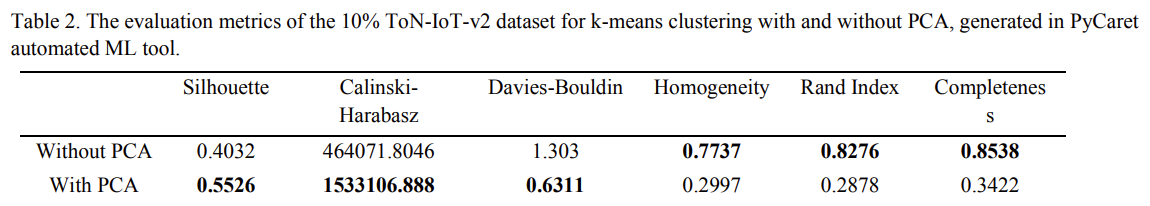